In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Investigation

The first step in any data science project is to get to know your data.

In [2]:
idot = pd.read_csv('../../data/idot_abbrv.csv')
idot.head()

,year,reason,any_search,search_hit,driver_race,beat,district
0,2019,moving,0,0,black,215,2
1,2019,equipment,0,0,white,2422,24
2,2019,moving,0,0,black,1522,15
3,2019,moving,0,0,black,2432,24
4,2019,moving,0,0,hispanic,2423,24


In [3]:
idot.shape

(925805, 7)

Our dataset has seven columns and 925,805 rows where each row is a traffic stop that occurred in Chicago. 

According to IDOT, the seven variables can be described as follows:
- `year` - the year the traffic stop happened
- `reason` - the reason for the stop, one of: moving, equipment, license, or none
- `any_search` - a boolean variable indicating whether (1) or not (0) the car or any of its passengers were searched during the traffic stop
- `search_hit` - a boolean variable indicating whether (1) or not (0) anything illegal was found during a search (value is 0 if no search was conducted)
- `driver_race` - perceived race of the driver as reported by the officer, one of: black, white, hispanic, asian, am_indian, or other
- `beat` - the police beat in which the traffic stop occurred (first 2 digits indicate the surrounding police district)
- `district` - the police district in which the traffic stop occurred

Let's look at these variables more closely.

In [4]:
idot.year.unique()

array([2019, 2020])

Using `.unique()`, we can see that the dataset includes stops from the years 2019-2020, but we are only interested in 2020. Let's filter the data so that we only have data for 2020.

In [5]:
idot_20 = idot.loc[idot.year == 2020].reset_index(drop=True)
idot_20.head()

,year,reason,any_search,search_hit,driver_race,beat,district
0,2020,moving,0,0,am_indian,1024,10
1,2020,moving,0,0,hispanic,433,4
2,2020,equipment,0,0,black,1021,10
3,2020,equipment,0,0,black,735,7
4,2020,moving,0,0,black,2011,20


In [6]:
idot_20.shape

(327290, 7)

Now, we have 327,290 stops in our data. There is a lot of interesting data here including whether the car was searched, if the officer found contraband (called a 'hit'), and where the stop occurred (the police district and beat). For example, Hyde Park is in district 2. Let's see how many stops occurred in district 2.

In [7]:
idot_20.groupby("district")["reason"].count()

district
1      9347
2     15905
3     14510
4     20800
5      8567
6     11035
7     27101
8     17449
9     12383
10    24979
11    41736
12    14788
14     8468
15    24066
16     4575
17     7994
18     9588
19     7132
20     8118
22     5729
24     7542
25    23515
31     1963
Name: reason, dtype: int64

So, there were 15,905 traffic stops made in the district surrounding Hyde Park in 2020. 

We can create a histogram to see the distribution of numbers of stops per police beat.

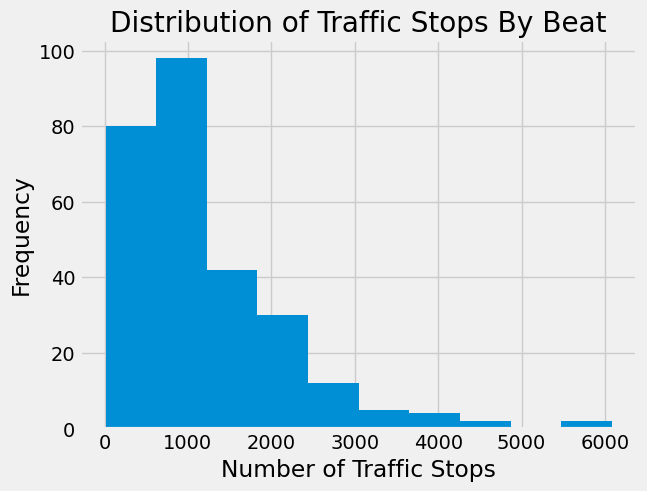

In [8]:
plt.hist(idot_20.groupby("beat")["reason"].count());
plt.xlabel("Number of Traffic Stops")
plt.ylabel("Frequency")
plt.title("Distribution of Traffic Stops By Beat")
plt.show()

This shows that there is a wide range of numbers of stops in each police beat. The variability we see is likely due to a number of factors including unequal population and land area between beats as well as differing road size and traffic levels. 

Two beats have around 6,000 stops, more than any other beat in 2020. Let's identify those beats.

In [9]:
stop_counts = idot_20.groupby("beat")[["reason"]].count()
stop_counts[stop_counts.reason > 5000]

,reason
beat,
1112,6081
1533,5875


Upon inspection, these beats are both west of downtown Chicago and beat 1533 contains part of interstate 290.

We can also investigate the reason for the traffic stops.

In [10]:
idot_20.groupby("reason")["district"].count()

reason
equipment    131250
license       66398
moving       129638
none              4
Name: district, dtype: int64

In 2020, 129,638 people were stopped for moving violations (like speeding or not using a blinker), 131,250 were stopped because of equipment (like a burnt out taillight), 66,398 were stopped for an invalid license, and there were 4 cases where the reason was not entered in the database. 

## Traffic Stops

This is all very interesting, but we wanted to investigate the stop rates for drivers of different races. We can do this using the variable `driver_race`. First, let's drop some of the columns that we don't need for now.

In [11]:
idot_20_abbrv = idot_20.drop(columns=["reason","beat","district"])
idot_20_abbrv

,year,any_search,search_hit,driver_race
0,2020,0,0,am_indian
1,2020,0,0,hispanic
2,2020,0,0,black
3,2020,0,0,black
4,2020,0,0,black
...,...,...,...,...
327285,2020,0,0,asian
327286,2020,0,0,black
327287,2020,0,0,white
327288,2020,0,0,black


Recall, we also could have selected only the columns we wanted instead of dropping the columns we didn't need (see [Chapter 6](../../06/DataFrames.ipynb)).

Now, let's group the data by `driver_race` and count how many drivers of each race were stopped in 2020.

In [12]:
stopped = idot_20_abbrv.groupby("driver_race")["year"].count().reset_index().rename(columns={"year":"num_stopped"})
stopped

,driver_race,num_stopped
0,am_indian,1176
1,asian,7448
2,black,204203
3,hispanic,78449
4,other,895
5,white,35053


From this table, it certainly looks like more Black and Hispanic drivers were stopped in 2020 than drivers of other races. However, we are only looking at raw counts. It will be easier to see a pattern if we convert these counts to a proportion of total stops and then visualize the data.

In [13]:
stopped['prop_stopped'] = np.round(stopped['num_stopped'] / 327290, decimals=4)
stopped

,driver_race,num_stopped,prop_stopped
0,am_indian,1176,0.0036
1,asian,7448,0.0228
2,black,204203,0.6239
3,hispanic,78449,0.2397
4,other,895,0.0027
5,white,35053,0.1071


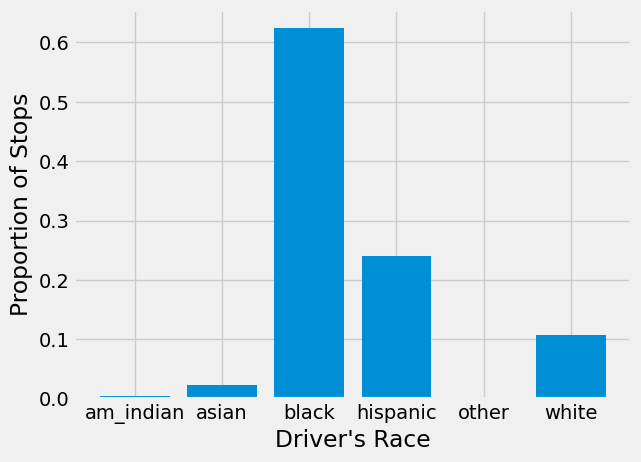

In [14]:
plt.bar(stopped['driver_race'], stopped["prop_stopped"])
plt.xlabel("Driver's Race")
plt.ylabel("Proportion of Stops")
plt.show()

From this figure, we can see that approximately 62% of drivers stopped were Black, 24% were Hispanic, and 11% were White.

### The Benchmark

In order to do a benchmark analysis, we need a benchmark for comparison, in this case, the population of Chicago. Next, we will read-in data on the estimated driving population of each race by beat. This dataset was created by a research team at the University of Chicago Data Science Institute. 

Note that these benchmark populations are not integers. This data was estimated probabilistically using data on age and race of drivers (see the explanation in the [previous section](../1/background.ipynb)) which resulted in continuous estimates.

In [35]:
pop = pd.read_csv('../../data/adjusted_population_beat.csv')
pop[["White","Black","Hispanic","Asian","Native","Other"]] = pop[["White","Black","Hispanic","Asian","Native","Other"]].apply(np.round, decimals=4)
pop.head()

,beat,White,Black,Hispanic,Asian,Native,Other
0,1713,1341.0698,1865.3001,937.4999,317.0765,0.0000,0.0
1,1651,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
2,1914,641.2881,5878.7811,1621.2010,407.4879,0.0000,0.0
3,1915,1178.3223,1331.1240,1597.0273,283.1750,0.0000,0.0
4,1913,739.5932,2429.8962,535.7215,121.0840,159.0156,0.0


Since, we are interested in Chicago as a whole, we can sum over beats to get the estimated population for all of Chicago.

In [36]:
pop_total = pop.sum(axis=0).to_frame(name="est_pop").reset_index().rename(columns={'index': 'driver_race'})
pop_total

,driver_race,est_pop
0,beat,335962.0000
1,White,298755.1974
2,Black,248709.5311
3,Hispanic,222341.2245
4,Asian,60069.7684
5,Native,2664.8764
6,Other,212.5375


Clearly, the beat row gives us no useful information, so let's drop it.

In [17]:
pop_total = pop_total.drop([0])
pop_total

,driver_race,est_pop
1,White,298755.1974
2,Black,248709.5311
3,Hispanic,222341.2245
4,Asian,60069.7684
5,Native,2664.8764
6,Other,212.5375


Now, we can calculate proportions of the population, similar to what we did with number of traffic stops above.

In [18]:
pop_total['prop_pop'] = np.round(pop_total['est_pop'] / pop_total['est_pop'].sum(), decimals=4)
pop_total

,driver_race,est_pop,prop_pop
1,White,298755.1974,0.3588
2,Black,248709.5311,0.2987
3,Hispanic,222341.2245,0.2670
4,Asian,60069.7684,0.0721
5,Native,2664.8764,0.0032
6,Other,212.5375,0.0003


We want to compare these proportions with the proportion of stops we calculated above. To make this comparison easier, we should put everything in the same DataFrame. We can combine them with `merge`, but first we need to make sure the race labels match across both DataFrames.

- In one DataFrame, the race names are capitalized.
- In the other, they are lowercase.
- There’s also a naming difference: one uses "native", while the other uses "am_indian".

We need to fix these inconsistencies before merging.

Back in [Chapter 3](../../03/4/Strings.ipynb), we learned that you can convert a string to lowercase with the method `Series.str.lower()`. Since this method already works element-wise on every string in a Series, we don’t need to wrap it in `.apply()`. Using it directly is both simpler and faster.

In [ ]:
pop_total['driver_race'] = pop_total['driver_race'].str.lower()
pop_total

,driver_race,est_pop,prop_pop
1,white,298755.1974,0.3588
2,black,248709.5311,0.2987
3,hispanic,222341.2245,0.2670
4,asian,60069.7684,0.0721
5,am_indian,2664.8764,0.0032
6,other,212.5375,0.0003


The `.replace()` method can take a dictionary that maps old values to new ones. This lets us standardize categories by substituting one label for another.

In our case, we want to map all occurrences of "native" to "am_indian". By passing in a dictionary like `{"native": "am_indian"}`, every "native" in the Series will be replaced with "am_indian".

In [20]:
race_map = {"native":"am_indian"}

pop_total['driver_race'] = pop_total['driver_race'].replace(race_map)
pop_total

,driver_race,est_pop,prop_pop
1,white,298755.1974,0.3588
2,black,248709.5311,0.2987
3,hispanic,222341.2245,0.2670
4,asian,60069.7684,0.0721
5,am_indian,2664.8764,0.0032
6,other,212.5375,0.0003


In [21]:
stops_vs_pop = stopped.merge(pop_total)
stops_vs_pop

,driver_race,num_stopped,prop_stopped,est_pop,prop_pop
0,am_indian,1176,0.0036,2664.8764,0.0032
1,asian,7448,0.0228,60069.7684,0.0721
2,black,204203,0.6239,248709.5311,0.2987
3,hispanic,78449,0.2397,222341.2245,0.2670
4,other,895,0.0027,212.5375,0.0003
5,white,35053,0.1071,298755.1974,0.3588


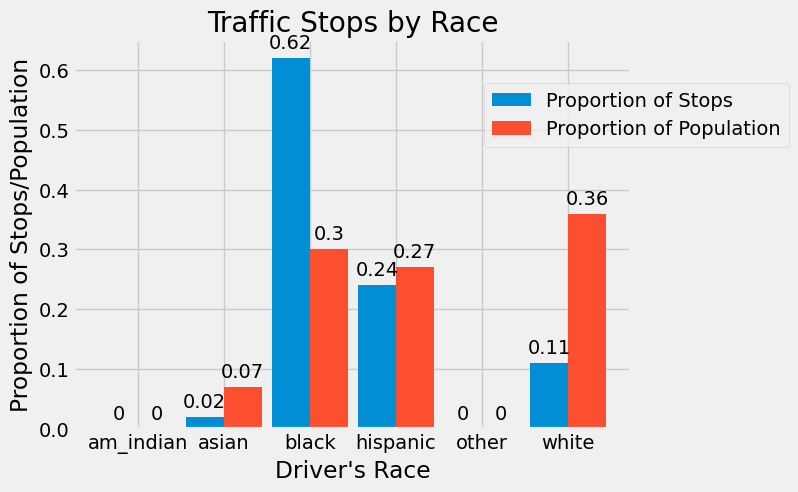

In [22]:
x = np.arange(len(stops_vs_pop.driver_race))  # the label locations
width = 0.44  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x, round(stops_vs_pop.prop_stopped,2), width, label="Proportion of Stops")
ax.bar_label(rects1, padding=4)

rects2 = ax.bar(x + width, round(stops_vs_pop.prop_pop,2), width, label="Proportion of Population")
ax.bar_label(rects2, padding=4)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Proportion of Stops/Population')
ax.set_xlabel("Driver's Race")
ax.set_title('Traffic Stops by Race')
ax.set_xticks(x + width/2, stops_vs_pop.driver_race)
ax.legend(loc=4, bbox_to_anchor=(1.3, 0.7))

plt.show()

Using this figure, we can see that American Indian, Hispanic, and Other drivers are all stopped at a proportion that is similar to the proportion of the population they make up. However, Black drivers are stopped twice as often as we would expect to see according to their population, and Asian and White drivers are stopped at rates less than their proportion of the population.

## Searches

Our data doesn't just have information on stops. It also has information on whether the driver or car were searched during the traffic stop. Let's investigate searches and hits by race as well. This type of investigation is called an **outcomes analysis** since we are comparing the outcomes (hits) of searches. 

In [23]:
searched = idot_20_abbrv.groupby("driver_race")[["any_search","search_hit"]].sum().reset_index().rename(columns={"any_search":"num_searched", "search_hit":"num_hit"})
searched

,driver_race,num_searched,num_hit
0,am_indian,3,1
1,asian,31,12
2,black,3712,980
3,hispanic,1140,317
4,other,5,3
5,white,190,66


Again, let's convert counts to proportions. For number of searches, we will convert to proportion of total searches. For number of hits, we will convert to proportion of searches that resulted in a hit. 

In [24]:
searched['prop_searched'] = np.round(searched['num_searched'] / searched['num_searched'].sum(), decimals=4)
searched

,driver_race,num_searched,num_hit,prop_searched
0,am_indian,3,1,0.0006
1,asian,31,12,0.0061
2,black,3712,980,0.7306
3,hispanic,1140,317,0.2244
4,other,5,3,0.0010
5,white,190,66,0.0374


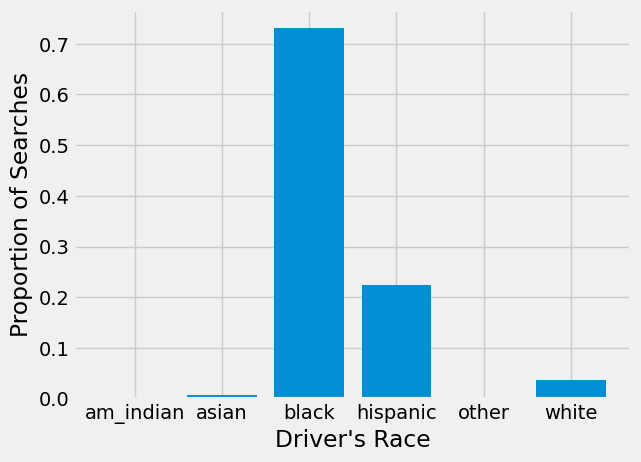

In [25]:
plt.bar(searched['driver_race'], searched["prop_searched"])
plt.xlabel("Driver's Race")
plt.ylabel("Proportion of Searches")
plt.show()

We can see from this barchart that Black drivers are searched much more often than drivers of any other race. Over 70% of searches conducted in 2020 were of Black drivers!

Are these searches successful? If these were necessary searches, officers should be finding contraband more often when searching Black drivers.

In [26]:
searched['prop_hit'] = np.round(searched['num_hit'] / searched['num_searched'], decimals=4)
searched

,driver_race,num_searched,num_hit,prop_searched,prop_hit
0,am_indian,3,1,0.0006,0.3333
1,asian,31,12,0.0061,0.3871
2,black,3712,980,0.7306,0.2640
3,hispanic,1140,317,0.2244,0.2781
4,other,5,3,0.0010,0.6000
5,white,190,66,0.0374,0.3474


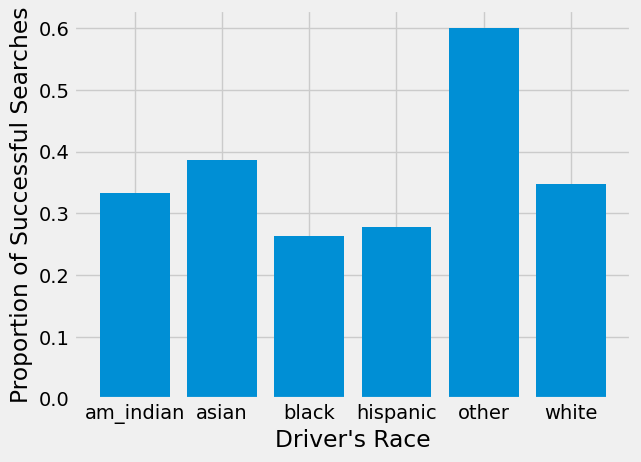

In [27]:
plt.bar(searched['driver_race'], searched["prop_hit"])
plt.xlabel("Driver's Race")
plt.ylabel("Proportion of Successful Searches")
plt.show()

American Indian, Asian, and other drivers all have small numbers of searches. Focusing on the 3 races with enough searches to analyze, we see that, despite being searched more often, searches of Black drivers result in  a hit slightly less often than searches of White drivers. 

We see a slightly taller bar for White drivers in the previous barchart. It would be interesting to know if contraband is found on White drivers significantly more often than Black drivers. Let's add a confidence interval to the point estimates shown in the plot. We will focus on the three most common races in our data: Black, Hispanic, and White.

First, we create 1000 bootstrap samples and calculate hit proportions for White, Black, and Hispanic drivers in each sample.

In [28]:
props_white = np.array([])
props_black = np.array([])
props_hispanic = np.array([])
for i in np.arange(1000):
    bootstrap_sample = idot_20_abbrv.sample(len(idot_20_abbrv),replace=True)
    searches = bootstrap_sample.groupby("driver_race")[["any_search","search_hit"]].sum().reset_index().rename(columns={"any_search":"num_searched", "search_hit":"num_hit"})
    searches['prop_hit'] = searches['num_hit'] / searches['num_searched']
    resampled_white = searches[searches.driver_race == "white"]["prop_hit"]
    resampled_black = searches[searches.driver_race == "black"]["prop_hit"]
    resampled_hispanic = searches[searches.driver_race == "hispanic"]["prop_hit"]
    props_white = np.append(props_white, resampled_white)
    props_black = np.append(props_black, resampled_black)
    props_hispanic = np.append(props_hispanic, resampled_hispanic)

white_ci = np.percentile(props_white, [2.5,97.5])
black_ci = np.percentile(props_black, [2.5,97.5])
hispanic_ci = np.percentile(props_hispanic, [2.5,97.5])

Now that we have our three 95% bootstrap confidence intervals, we need to get them in the correct format to make error bars on our graph. The method `.T` transposes a 2-D array or matrix. In this case, we need all lower limits in one row and all upper limits in another, so we transpose our array and then make it back into a list. The argument that creates error bars also needs the upper and lower limits in the format of distances from the top of the bar in a barchart so we subtract to find those distances.

In [29]:
searched3 = searched.loc[searched.driver_race.isin(['white','black','hispanic'])]

errors = np.array([black_ci, hispanic_ci, white_ci]).T.tolist()
low = searched3["prop_hit"] - errors[0]
high = errors[1] - searched3["prop_hit"]

Now, we can plot our barchart and include the confidence interval we calculated.

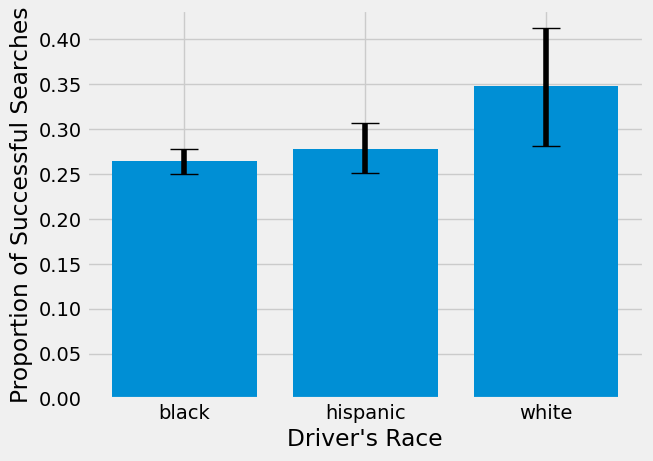

In [30]:
plt.bar(searched3['driver_race'], searched3["prop_hit"], yerr=[low,high], capsize=10)
plt.xlabel("Driver's Race")
plt.ylabel("Proportion of Successful Searches")
plt.show()

The 95% bootstrap confidence intervals for Black and Hispanic and Hispanic and White seem to overlap, but those for Black and White don't, indicating there is a significant difference between the two. Let's double check this with a hypothesis test for the difference in proportion of successful searches between Black and White drivers.

We will conduct a two-sided permutation test. The null hypothesis for our test is that there is no difference in proportion of successful searches between Black and White drivers. Our alternative hypothesis is that there is a difference.

```{note}
In the following simulation, we use `Series.isin()` to check whether values in a Series are part of a sequence.  

You’ve already seen the `in` operator, which checks membership for a *single element*. With `pandas`, we often want to check membership for every element in a Series at once. That’s what Series.isin() does — it returns a boolean Series showing, for each element, whether it’s contained in the given list (or other sequence). 
```

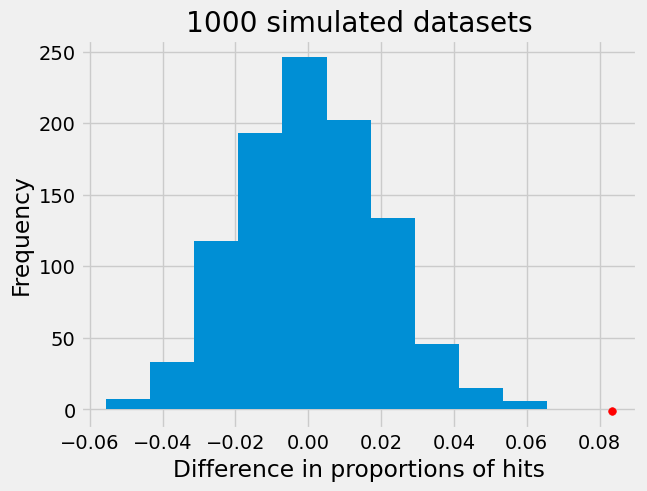

In [32]:
np.random.seed(42)
differences = np.array([])
shuffled_dat = idot_20_abbrv.loc[idot_20_abbrv.driver_race.isin(['white','black'])].copy()

for i in np.arange(1000):
    shuffled_dat['shuffled_races'] = np.random.permutation(shuffled_dat["driver_race"])
    shuffle_searched = shuffled_dat.groupby("shuffled_races")[["any_search","search_hit"]].sum().reset_index().rename(columns={"any_search":"num_searched", "search_hit":"num_hit"})
    shuffle_searched['prop_hit'] = shuffle_searched['num_hit'] / shuffle_searched['num_searched']
    diff = shuffle_searched.loc[shuffle_searched['shuffled_races'] == 'white','prop_hit'].iloc[0] - shuffle_searched.loc[shuffle_searched['shuffled_races'] == 'black','prop_hit'].iloc[0]
    differences = np.append(differences, diff)

data_diff = searched3.loc[searched3['driver_race'] == 'white','prop_hit'].iloc[0] - searched3.loc[searched3['driver_race'] == 'black','prop_hit'].iloc[0]
plt.hist(differences)
plt.scatter(data_diff, -1, color='red', s=30)
plt.title('1000 simulated datasets');
plt.xlabel("Difference in proportions of hits");
plt.ylabel("Frequency");

Our permutation test shows that the difference in proportions we see in our data is not consistent with what we would expect if there was no difference between the two groups. In fact, the red dot does not overlap with our histogram at all indicating our p-value is 0. So, we can reject the null hypothesis that Black and White drivers have similar proportions of search hits, and conclude that contraband is found on Black drivers at a significantly lower rate than White drivers!

## Conclusions

We've showed two different strategies for investigating racial bias: benchmarking and outcomes analysis. Both strategies have been used by real data scientists in cities like Chicago, Nashville, and New York to detect biased police practices. 

This case study shows that you can answer important data science questions with the information you have learned so far in this book. Skills like grouping and merging, creating and dropping columns in DataFrames, and applying functions to a column are all extremely useful and used very often in data science.

In addition, our investigation of traffic stops illustrates the wide variety of important data science projects. Projects like this have the potential to influence policy and legislation. Other data science projects can affect development of new medications or therapies, help understand history, or lead to technology like Chat-GPT or Google BARD. 

However, many of these projects involve additional statistical and computation skills like machine learning or being able to use large amounts of data from databases. These more advanced topics are what we will cover in Part 2 of this book.